In [31]:
from __future__ import annotations

from collections.abc import Sequence

import datasets
import numpy as np
from tqdm import tqdm


def process(
    dataset_name: str,
    *,
    id_column: str,
    natoms_column: str,
    atomic_numbers_column: str,
    energy_column: str | Sequence[str],
    force_column: str | None,
    stress_column: str | None,
    split: str = "train",
    count: int = 10_000,
):
    ids = set()

    natoms = []
    atomic_numbers = []
    energies = []
    forces = []
    stresses = []

    i = 0
    pbar = tqdm(total=count)
    printed = False
    for data_dict in datasets.load_dataset(dataset_name, split=split, streaming=True):
        if not printed:
            print({k: type(v) for k, v in data_dict.items()})
            printed = True
        if i >= count:
            break

        id = data_dict[id_column]
        if id in ids:
            continue

        i += 1
        pbar.update(1)

        ids.add(id)
        natoms.append(natoms_ := data_dict[natoms_column])
        atomic_numbers.append(data_dict[atomic_numbers_column])
        if isinstance(energy_column, str):
            energy = data_dict[energy_column]
        else:
            energy = sum(data_dict[col] for col in energy_column)
        energies.append(energy / natoms_)

        if force_column is not None:
            forces.append(np.linalg.norm(np.array(data_dict[force_column]), axis=-1))
        if stress_column is not None:
            stresses.append(np.trace(np.array(data_dict[stress_column]).reshape(3, 3)))

    return {
        "natoms": natoms,
        "atomic_numbers": atomic_numbers,
        "energies": energies,
        "forces": forces or None,
        "stresses": stresses or None,
    }


stats = {}

In [32]:
stats["mptrj"] = process(
    "nimashoghi/mptrj",
    id_column="mp_id",
    natoms_column="num_atoms",
    atomic_numbers_column="numbers",
    energy_column="corrected_total_energy",
    force_column="forces",
    stress_column="stress",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  2%|▏         | 209/10000 [00:01<00:59, 165.51it/s]

{'numbers': <class 'list'>, 'positions': <class 'list'>, 'forces': <class 'list'>, 'cell': <class 'list'>, 'pbc': <class 'list'>, 'energy': <class 'float'>, 'stress': <class 'list'>, 'e_per_atom_relaxed': <class 'float'>, 'mp_id': <class 'str'>, 'energy_per_atom': <class 'float'>, 'ef_per_atom_relaxed': <class 'float'>, 'corrected_total_energy': <class 'float'>, 'ef_per_atom': <class 'float'>, 'task_id': <class 'str'>, 'calc_id': <class 'int'>, 'ionic_step': <class 'int'>, 'filename': <class 'str'>, 'extxyz_id': <class 'int'>, 'num_atoms': <class 'int'>, 'corrected_total_energy_relaxed': <class 'float'>, 'energy_referenced': <class 'float'>, 'corrected_total_energy_referenced': <class 'float'>, 'corrected_total_energy_relaxed_referenced': <class 'float'>, 'composition': <class 'list'>}


100%|██████████| 10000/10000 [00:08<00:00, 1238.57it/s]


In [26]:
stats["wbm"] = process(
    "nimashoghi/wbm",
    id_column="material_id",
    natoms_column="num_atoms",
    atomic_numbers_column="atomic_numbers",
    energy_column=["uncorrected_energy", "e_correction_per_atom_mp2020"],
    force_column=None,
    stress_column=None,
)

{'formula': <class 'str'>, 'n_sites': <class 'float'>, 'volume': <class 'float'>, 'uncorrected_energy': <class 'float'>, 'e_form_per_atom_wbm': <class 'float'>, 'e_above_hull_wbm': <class 'float'>, 'bandgap_pbe': <class 'float'>, 'wyckoff_spglib_initial_structure': <class 'str'>, 'uncorrected_energy_from_cse': <class 'float'>, 'e_correction_per_atom_mp2020': <class 'float'>, 'e_correction_per_atom_mp_legacy': <class 'float'>, 'e_form_per_atom_uncorrected': <class 'float'>, 'e_form_per_atom_mp2020_corrected': <class 'float'>, 'e_above_hull_mp2020_corrected_ppd_mp': <class 'float'>, 'site_stats_fingerprint_init_final_norm_diff': <class 'float'>, 'wyckoff_spglib': <class 'str'>, 'unique_prototype': <class 'bool'>, 'formula_from_cse': <class 'str'>, 'initial_structure': <class 'dict'>, 'id': <class 'str'>, 'material_id': <class 'str'>, 'frac_pos': <class 'list'>, 'cart_pos': <class 'list'>, 'pos': <class 'list'>, 'cell': <class 'list'>, 'num_atoms': <class 'int'>, 'atomic_numbers': <class 

  3%|▎         | 307/10000 [00:01<00:30, 317.80it/s]



















  0%|          | 2/10000 [01:31<127:06:02, 45.77s/it]











































100%|██████████| 10000/10000 [00:08<00:00, 1142.94it/s]


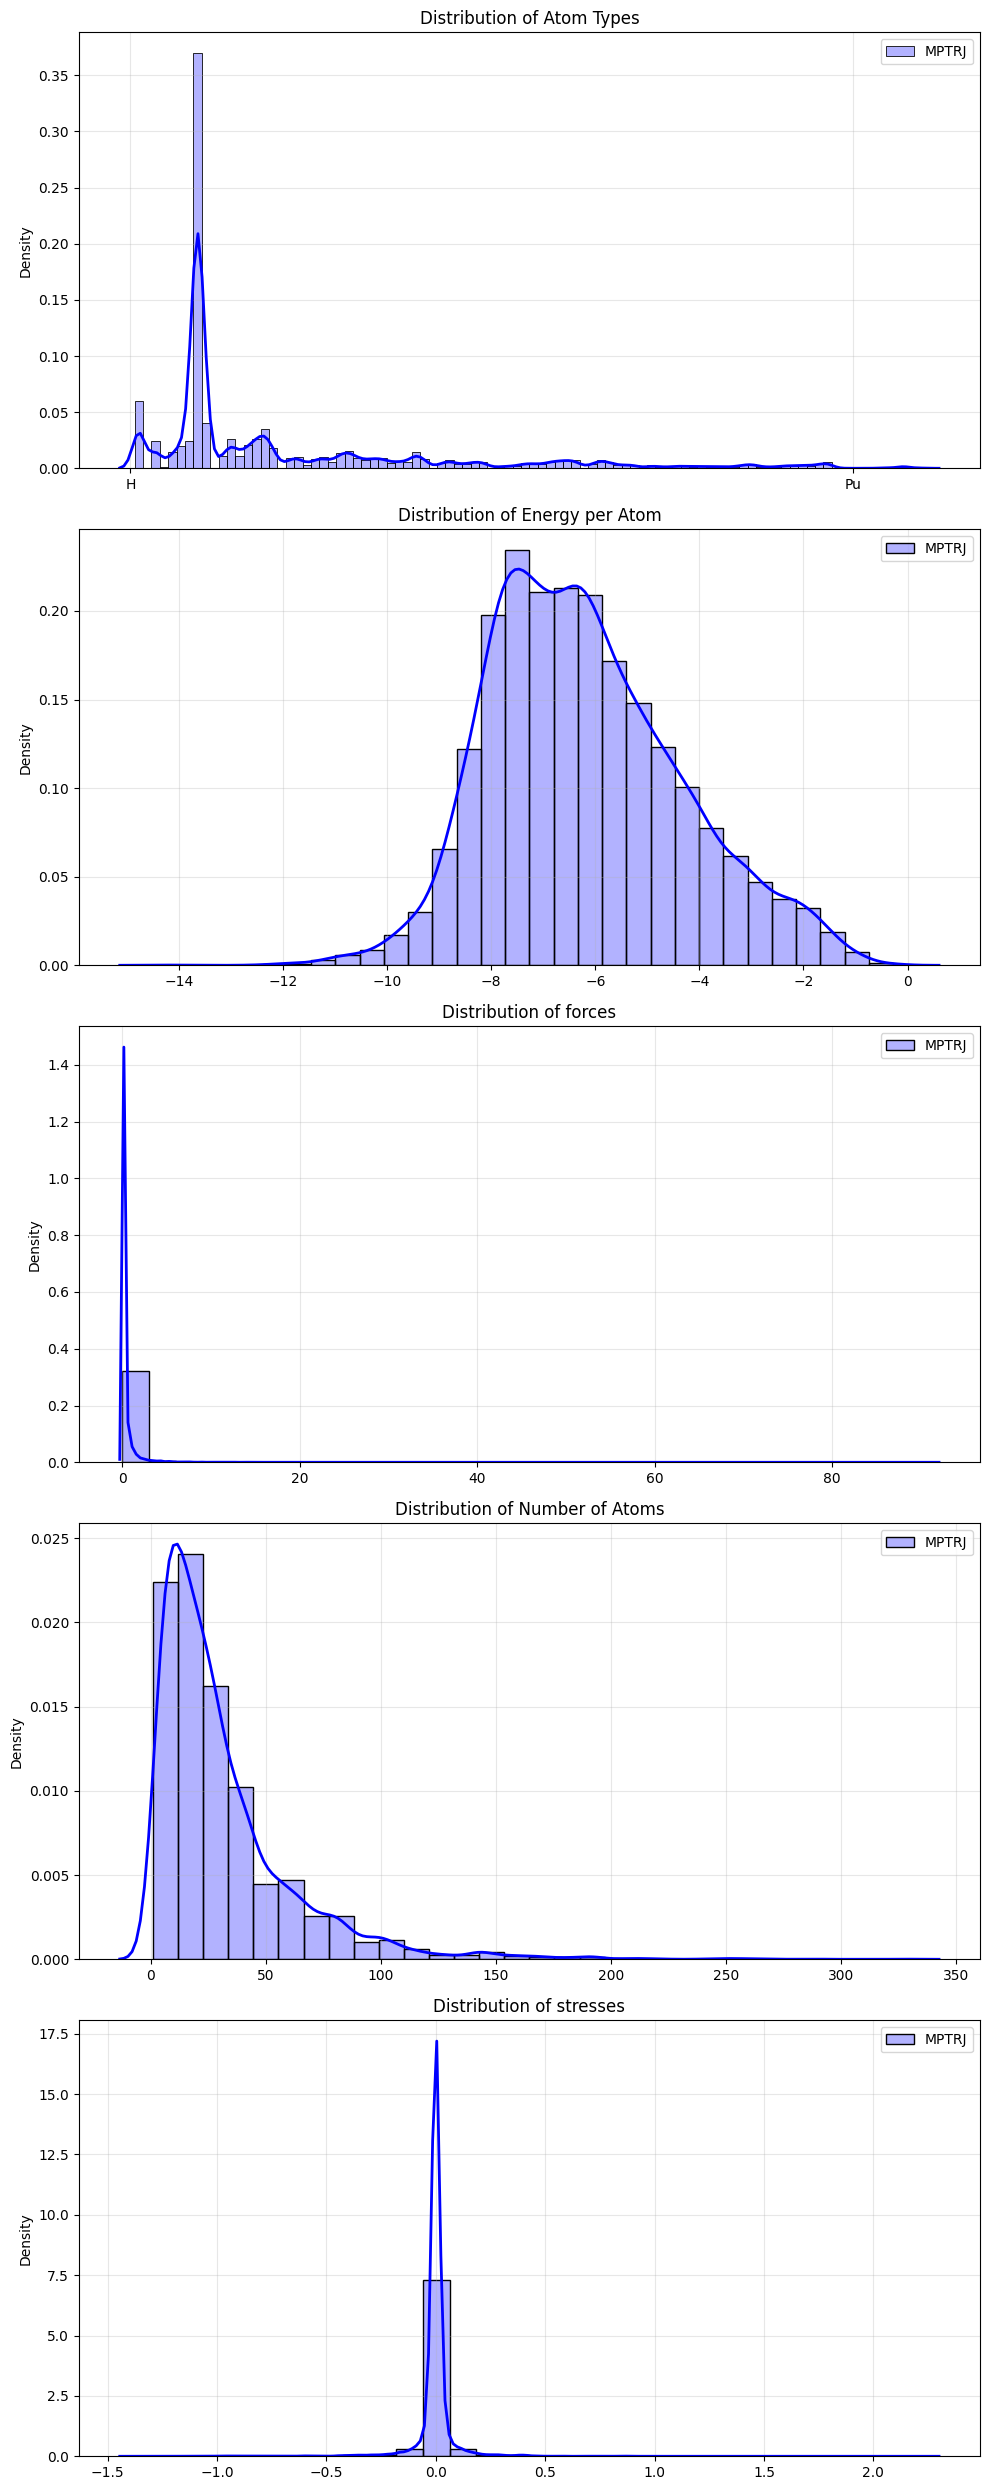

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ase.data import chemical_symbols


def plot_all_stats_distributions(
    stats,
    colors={"mptrj": "blue", "wbm": "orange"},
    name_mapping={},
):
    # Get all unique keys from the stats dictionary
    all_keys = set()
    for dataset_stats in stats.values():
        all_keys.update(dataset_stats.keys())

    # Create a subplot for each key
    n_keys = len(all_keys)
    fig, axes = plt.subplots(n_keys, 1, figsize=(10, 5 * n_keys))
    if n_keys == 1:
        axes = [axes]

    for ax, key in zip(axes, sorted(all_keys)):
        if key == "atomic_numbers":
            # Special handling for atomic numbers
            # Get all unique atomic numbers across both datasets
            all_atomic_numbers = set()
            for s in stats.values():
                atomic_numbers_flat = np.concatenate(s["atomic_numbers"])
                all_atomic_numbers.update(atomic_numbers_flat)

            # Convert to sorted list and get corresponding symbols
            all_atomic_numbers = sorted(list(all_atomic_numbers))
            all_atomic_symbols = [chemical_symbols[num] for num in all_atomic_numbers]
            x_positions = np.arange(len(all_atomic_symbols))

            # Plot for each dataset
            for dataset, s in stats.items():
                atomic_numbers_flat = np.concatenate(s["atomic_numbers"])
                unique_atomic_numbers, counts = np.unique(
                    atomic_numbers_flat, return_counts=True
                )
                densities = counts / len(atomic_numbers_flat)

                # Create a mapping of atomic numbers to densities
                density_map = dict(zip(unique_atomic_numbers, densities))

                # Create density array matching the full atomic numbers list
                plot_densities = np.array(
                    [density_map.get(num, 0) for num in all_atomic_numbers]
                )

                # Plot bars
                sns.histplot(
                    data=atomic_numbers_flat,
                    bins=np.arange(-0.5, len(all_atomic_numbers) + 0.5),
                    stat="density",
                    color=colors[dataset],
                    alpha=0.3,
                    label=dataset.upper(),
                    ax=ax,
                )

                # Add KDE
                # Create more points for smoother KDE
                x_kde = np.linspace(-1, len(all_atomic_numbers), 200)
                kde = sns.kdeplot(
                    data=atomic_numbers_flat,
                    color=colors[dataset],
                    ax=ax,
                    linewidth=2,
                    bw_adjust=0.5,  # Adjust this value to change smoothing
                )

            # Show only first (H) and last atomic symbols
            ax.set_xticks([0, len(all_atomic_symbols) - 1])
            ax.set_xticklabels([all_atomic_symbols[0], all_atomic_symbols[-1]])

        else:
            # First determine global min and max for this key
            all_values = []
            for dataset, s in stats.items():
                if s is None:
                    continue
                values = (
                    np.concatenate(s[key])
                    if isinstance(s[key][0], (list, np.ndarray))
                    else s[key]
                )
                all_values.extend(values)

            global_min = min(all_values)
            global_max = max(all_values)

            # Create consistent bins
            bins = np.linspace(global_min, global_max, 31)  # 31 edges = 30 bins

            # Plot histograms and KDE for each dataset
            for dataset, s in stats.items():
                if s is None:
                    continue
                values = (
                    np.concatenate(s[key])
                    if isinstance(s[key][0], (list, np.ndarray))
                    else s[key]
                )

                # Plot histogram
                sns.histplot(
                    data=values,
                    bins=bins,
                    alpha=0.3,
                    color=colors[dataset],
                    label=dataset.upper(),
                    stat="density",
                    ax=ax,
                )

                # Add KDE on top
                sns.kdeplot(
                    data=values,
                    color=colors[dataset],
                    ax=ax,
                    linewidth=2,
                )

        ax.set_title(f"Distribution of {name_mapping.get(key,key)}")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Use the function
plot_all_stats_distributions(
    stats,
    name_mapping={
        "natoms": "Number of Atoms",
        "atomic_numbers": "Atom Types",
        "energies": "Energy per Atom",
    },
)